<a href="https://colab.research.google.com/github/Cvelsen22/Carmelo-Velez---Data-Analysis-Portfolio/blob/main/Walmart_Sales_Prediction_Lasso_vs_Ridge_reg_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Data

This is the historical data that covers sales from 2010-02-05 to 2012-11-01, in the file Walmart_Store_sales. Within this file you will find the following fields:\

* Store - the store number
* Date - the week of sales
* Weekly_Sales - sales for the given store
* Holiday_Flag - whether the week is a special holiday week 1 – Holiday week 0 – Non-holiday week
* Temperature - Temperature on the day of sale
* Fuel_Price - Cost of fuel in the region
* CPI – Prevailing consumer price index
* Unemployment - Prevailing unemployment rate
* Holiday Events\
Super Bowl: 12-Feb-10, 11-Feb-11, 10-Feb-12, 8-Feb-13\
Labour Day: 10-Sep-10, 9-Sep-11, 7-Sep-12, 6-Sep-13\
Thanksgiving: 26-Nov-10, 25-Nov-11, 23-Nov-12, 29-Nov-13\
Christmas: 31-Dec-10, 30-Dec-11, 28-Dec-12, 27-Dec-13

In [112]:
# Import required modules
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, PolynomialFeatures , OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import cross_val_score, KFold
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.pipeline import make_pipeline

In [113]:
# Read in dataset
walmart = pd.read_csv("Walmart.csv")

In [114]:
walmart.isna().sum()

Store           0
Date            0
Weekly_Sales    0
Holiday_Flag    0
Temperature     0
Fuel_Price      0
CPI             0
Unemployment    0
dtype: int64

In [115]:
walmart.duplicated().sum()

0

In [116]:
walmart['Date'] = pd.to_datetime(walmart['Date'],dayfirst=True)
walmart['Month'] = walmart['Date'].dt.month
walmart['Year'] = walmart['Date'].dt.year

# Exploratory analysis

In [117]:
walmart.describe()

,Store,Weekly_Sales,Holiday_Flag,Temperature,Fuel_Price,CPI,Unemployment,Month,Year
count,6435.000000,6.435000e+03,6435.000000,6435.000000,6435.000000,6435.000000,6435.000000,6435.000000,6435.000000
mean,23.000000,1.046965e+06,0.069930,60.663782,3.358607,171.578394,7.999151,6.447552,2010.965035
std,12.988182,5.643666e+05,0.255049,18.444933,0.459020,39.356712,1.875885,3.238308,0.797019
min,1.000000,2.099862e+05,0.000000,-2.060000,2.472000,126.064000,3.879000,1.000000,2010.000000
25%,12.000000,5.533501e+05,0.000000,47.460000,2.933000,131.735000,6.891000,4.000000,2010.000000
50%,23.000000,9.607460e+05,0.000000,62.670000,3.445000,182.616521,7.874000,6.000000,2011.000000
75%,34.000000,1.420159e+06,0.000000,74.940000,3.735000,212.743293,8.622000,9.000000,2012.000000
max,45.000000,3.818686e+06,1.000000,100.140000,4.468000,227.232807,14.313000,12.000000,2012.000000


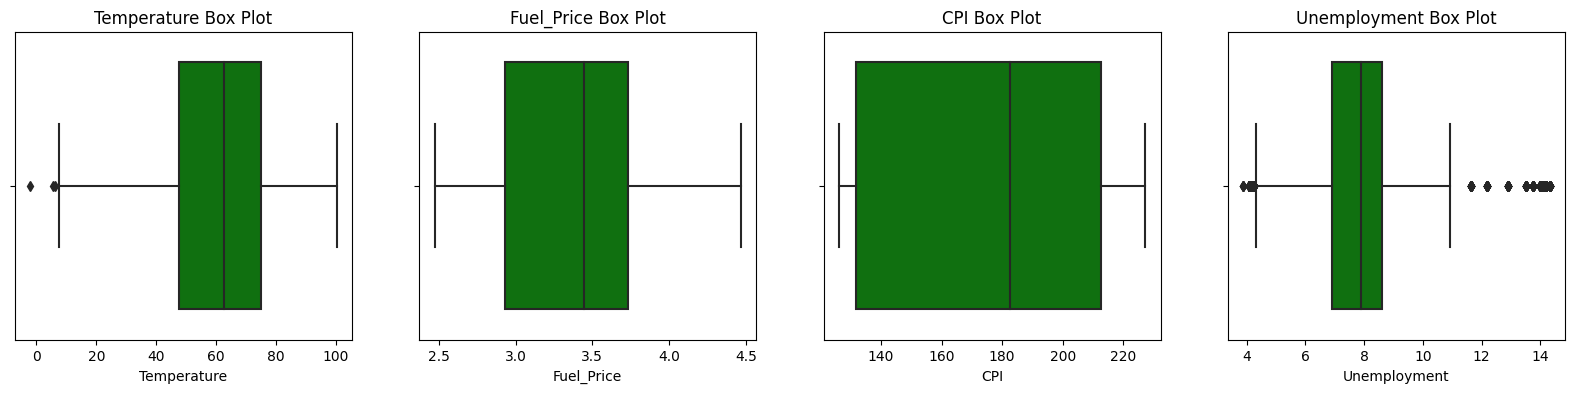

In [118]:
fig , ax = plt.subplots(1,4,figsize=(20,4))
cols = ['Temperature','Fuel_Price','CPI','Unemployment']
for i,col in enumerate(cols):
    sns.boxplot(walmart,
                 x=col,
                 ax=ax[i],
                 color = 'green'
                )
    ax[i].set_title(f'{col} Box Plot')
fig.show()

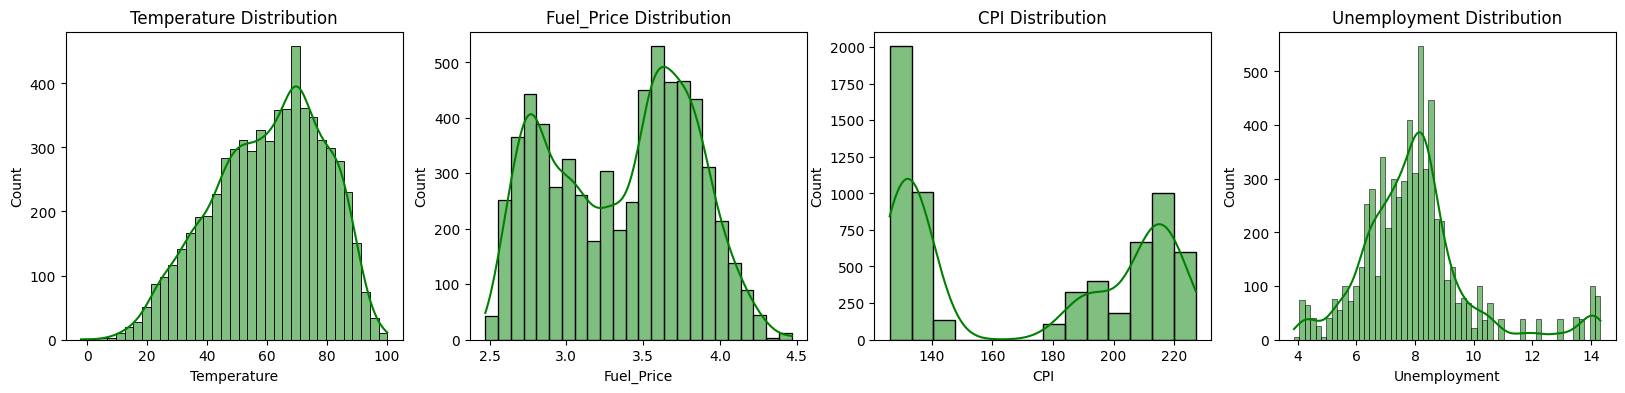

In [119]:
fig , ax = plt.subplots(1,4,figsize=(20,4))
cols = ['Temperature','Fuel_Price','CPI','Unemployment']
for i,col in enumerate(cols):
    sns.histplot(walmart,
                 x=col,
                 ax=ax[i],
                 kde=True,
                 color = 'green'
                )
    ax[i].set_title(f'{col} Distribution')
fig.show()

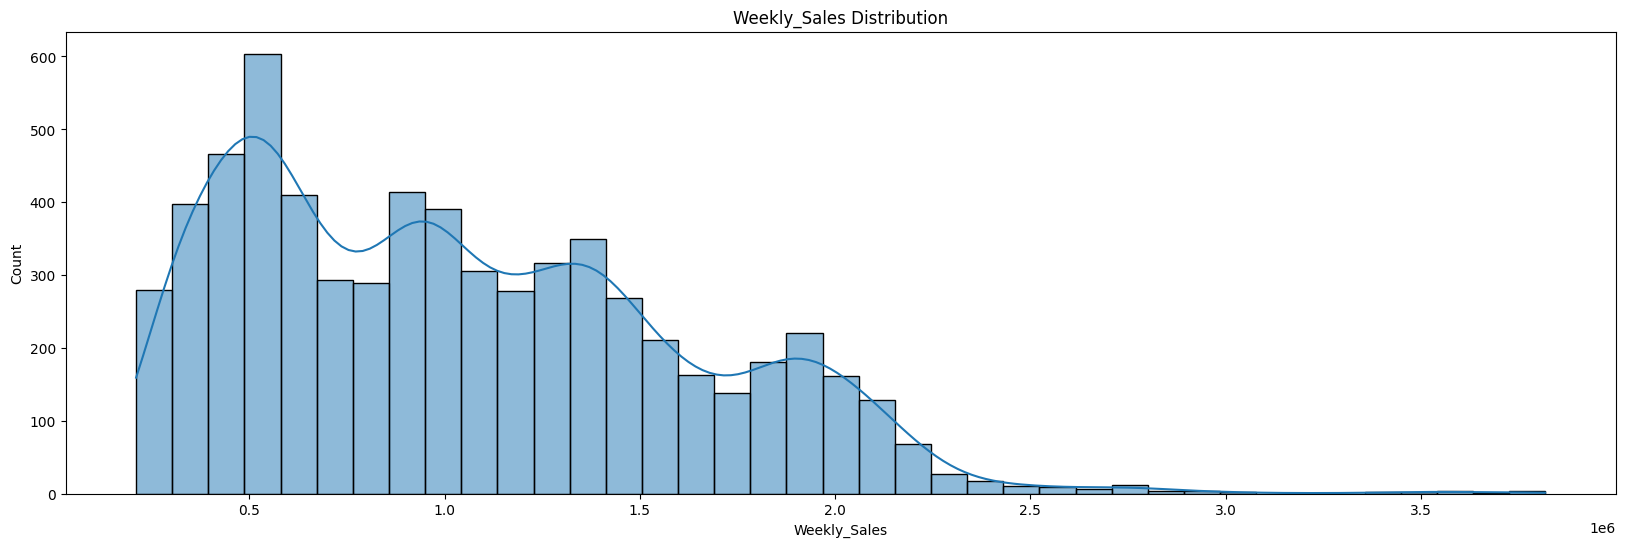

In [120]:
plt.figure(figsize=(20,6))
sns.histplot(x=walmart['Weekly_Sales'],kde=True);
plt.title('Weekly_Sales Distribution');

<ipython-input-121-43a454d63b9a>:2: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.lineplot(x = walmart["Month"],y = walmart['Weekly_Sales'],hue = walmart['Year'],ci=None);


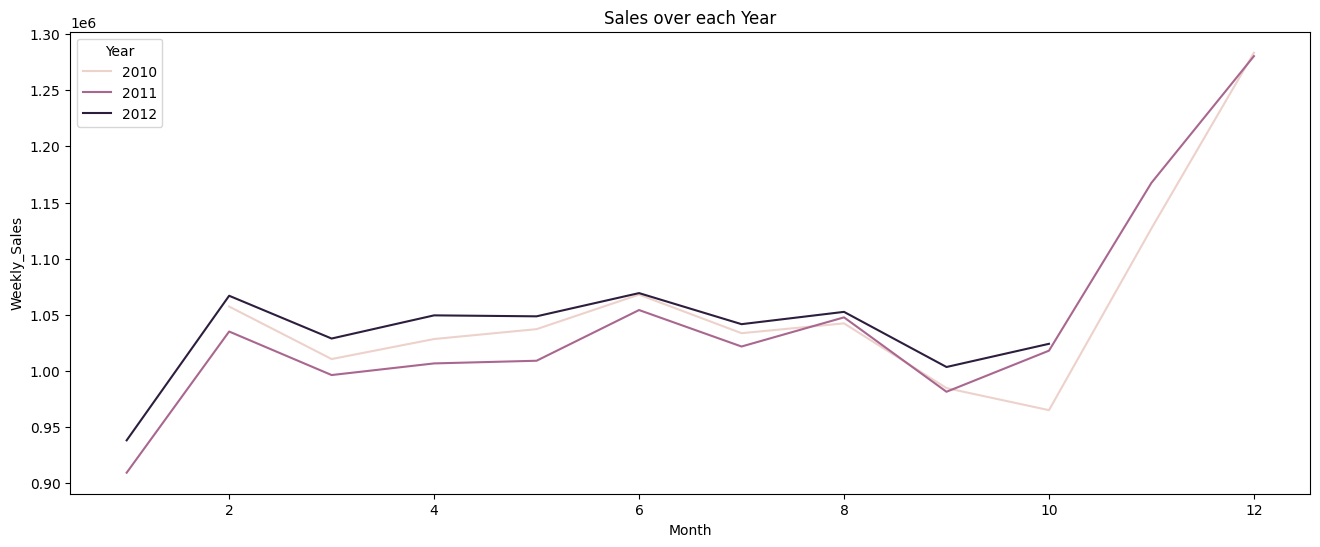

In [121]:
plt.figure(figsize=(16,6))
sns.lineplot(x = walmart["Month"],y = walmart['Weekly_Sales'],hue = walmart['Year'],ci=None);
plt.title('Sales over each Year');

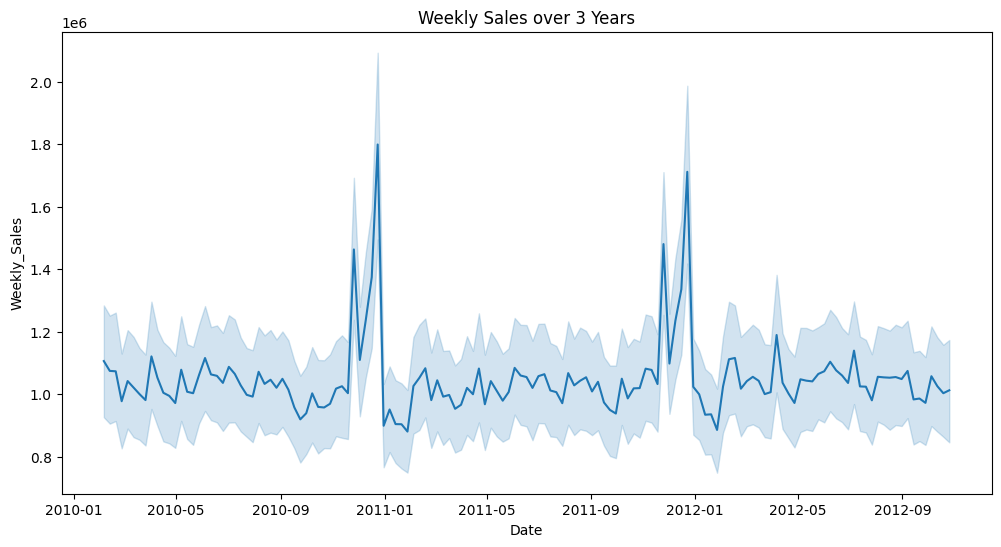

In [122]:
plt.figure(figsize=(12,6))
sns.lineplot(x=walmart["Date"],y=walmart['Weekly_Sales']);
plt.title('Weekly Sales over 3 Years');

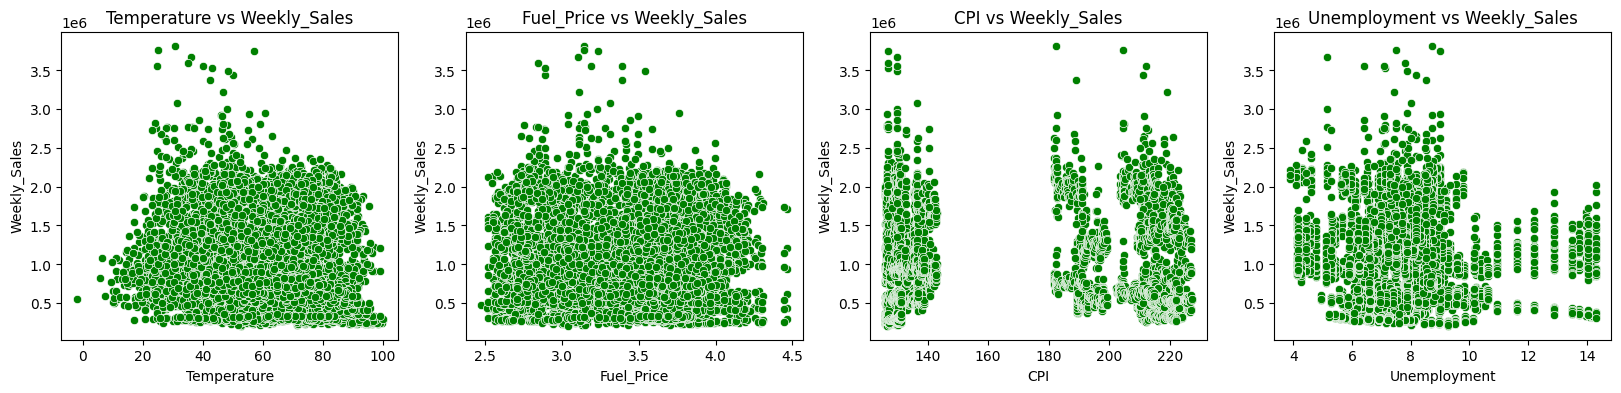

In [123]:
fig , ax = plt.subplots(1,4,figsize=(20,4))
cols = ['Temperature','Fuel_Price','CPI','Unemployment']
for i,col in enumerate(cols):
    sns.scatterplot(walmart,
                 y='Weekly_Sales',x=col,
                 ax=ax[i],
                 color = 'green'
                )
    ax[i].set_title(f'{col} vs Weekly_Sales')
fig.show()

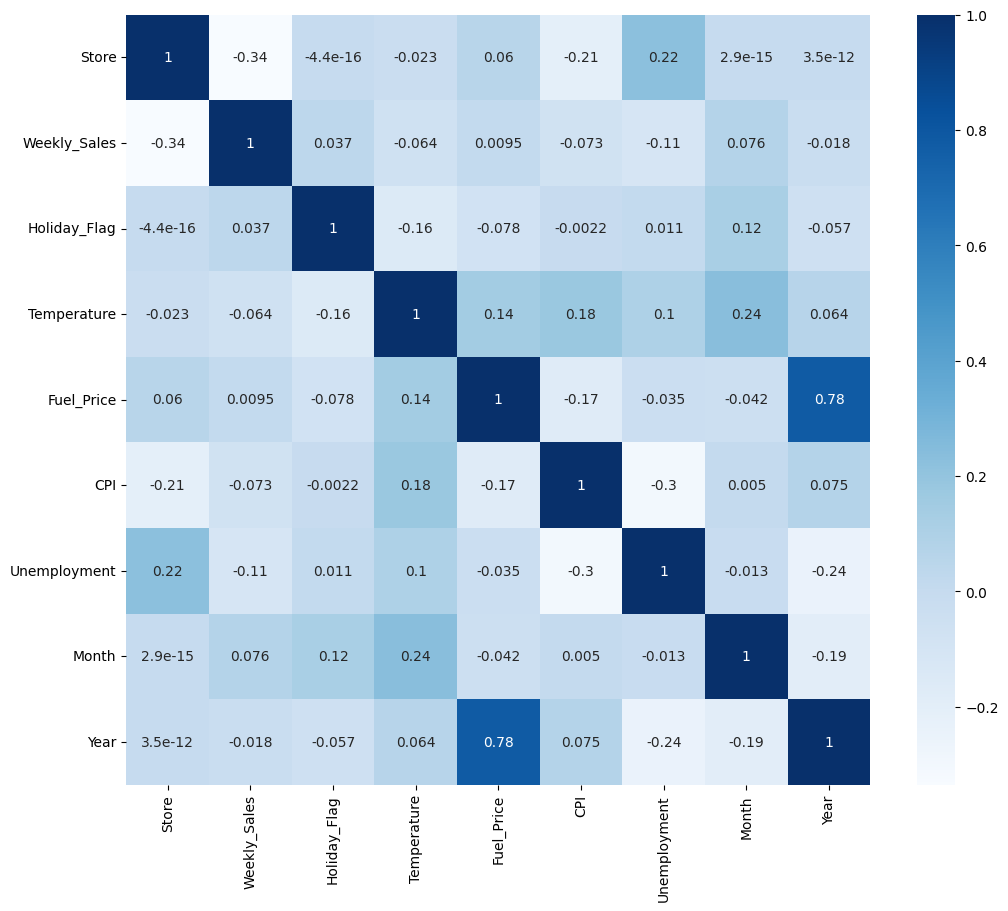

In [124]:
plt.figure(figsize=(12,10))
sns.heatmap(walmart.corr(numeric_only=True),cmap='Blues',annot=True);

In [125]:
num_features = ['Temperature','Fuel_Price','CPI','Unemployment','Weekly_Sales']
for feature in num_features:
    q1 = walmart[feature].quantile(0.25)
    q3 = walmart[feature].quantile(0.75)
    iqr = q3-q1
    lower = q1 - 1.5*iqr
    upper = q3 + 1.5*iqr
    preprocessed_data = walmart[(walmart[feature] >= lower) & (walmart[feature] <= upper)]

preprocessed_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6401 entries, 0 to 6434
Data columns (total 10 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   Store         6401 non-null   int64         
 1   Date          6401 non-null   datetime64[ns]
 2   Weekly_Sales  6401 non-null   float64       
 3   Holiday_Flag  6401 non-null   int64         
 4   Temperature   6401 non-null   float64       
 5   Fuel_Price    6401 non-null   float64       
 6   CPI           6401 non-null   float64       
 7   Unemployment  6401 non-null   float64       
 8   Month         6401 non-null   int64         
 9   Year          6401 non-null   int64         
dtypes: datetime64[ns](1), float64(5), int64(4)
memory usage: 550.1 KB


In [126]:
final_data = preprocessed_data.drop(['Store', 'Date'], axis = 1)
final_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6401 entries, 0 to 6434
Data columns (total 8 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Weekly_Sales  6401 non-null   float64
 1   Holiday_Flag  6401 non-null   int64  
 2   Temperature   6401 non-null   float64
 3   Fuel_Price    6401 non-null   float64
 4   CPI           6401 non-null   float64
 5   Unemployment  6401 non-null   float64
 6   Month         6401 non-null   int64  
 7   Year          6401 non-null   int64  
dtypes: float64(5), int64(3)
memory usage: 450.1 KB


# Fit and predict for regression

In [127]:
# Create X and y arrays
X = final_data.drop("Weekly_Sales", axis=1).values
y = final_data["Weekly_Sales"].values

In [128]:
# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [129]:
# Instantiate the model
reg = LinearRegression()

In [130]:
# Fit the model to the data
reg.fit(X_train,y_train)

LinearRegression()

In [131]:
# Make predictions
y_pred = reg.predict(X_test)
print("Predictions: {}, Actual Values: {}".format(y_pred[:5], y_test[:5]))

Predictions: [1043930.59217003  925580.69169284  946834.74738348 1085571.53594425
  966285.78673625], Actual Values: [1711562.73 1006814.85  432451.91 1261693.16 1597868.05]


# Lasso regression for feature importance

In [150]:
# Instantiate a lasso regression model
lasso = Lasso(alpha=0.01, max_iter=7000)

In [151]:
# Fit the model to the data
lasso.fit(X,y)

Lasso(alpha=0.01, max_iter=7000)

In [152]:
# Compute and print the coefficients
lasso_coef = lasso.fit(X,y).coef_
print("lasso_coef:", lasso_coef)

lasso_coef: [ 41933.79711641   -697.27029899  64769.06853808  -1323.75260106
 -42086.22326114   6590.74892611 -45279.98625539]


# Regression performance

In [135]:
# Compute R-squared
r_squared = reg.score(X_test, y_test)

In [136]:
# Compute RMSE
rmse = mean_squared_error(y_test, y_pred, squared=False)

In [137]:
# Print the metrics
print("R^2: {}".format(r_squared))
print("RMSE: {}".format(rmse))

R^2: 0.02394130242560455
RMSE: 547927.0732530449


In [138]:
# Compute R-squared
r_squared = reg.score(X_test, y_test)

# Cross-validation for R-squared

In [139]:
# Create a KFold object
kf = KFold(n_splits=10, shuffle=True, random_state=5)

In [140]:
# Compute 6-fold cross-validation scores
cv_scores = cross_val_score(reg, X, y, cv=kf)

In [141]:
# Print scores
print("scores:",cv_scores)

scores: [0.02193554 0.02794277 0.00398814 0.02333078 0.0168044  0.00813004
 0.02862211 0.02955196 0.02603856 0.03069855]


In [142]:
# Print the mean
print('mean:', np.mean(cv_scores))

# Print the standard deviation
print("standard deviation:", np.std(cv_scores))

# Print the 95% confidence interval
print("95% confidence interval:", np.quantile(cv_scores, [0.025, 0.975]))

mean: 0.02170428413794756
standard deviation: 0.00879132199705194
95% confidence interval: [0.00492007 0.03044056]


# Regularized regression: Ridge

In [143]:
alphas = [0.1, 1.0, 10.0, 100.0, 1000.0, 10000.0]
ridge_scores = []
for alpha in alphas:

  # Create a Ridge regression model
  ridge = Ridge(alpha=alpha)

  # Fit the data
  ridge.fit(X_train, y_train)

  # Obtain R-squared
  score = ridge.score(X_test, y_test)
  ridge_scores.append(score)
print("ridge_scores:", ridge_scores)

ridge_scores: [0.02394078154006507, 0.02393610011575953, 0.023889962831092793, 0.0235039510387417, 0.022398665535230955, 0.01919243907260937]


# Hyperparameter tuning with GridSearchCV

In [144]:
# Set up the parameter grid
param_grid = {"alpha": np.linspace(0.00001, 1, 20)}

In [145]:
# Instantiate lasso_cv
lasso_cv = GridSearchCV(lasso, param_grid, cv=kf)

In [146]:
# Fit to the training data
lasso_cv.fit(X_train,y_train)
print("Tuned lasso paramaters: {}".format(lasso_cv.best_params_))
print("Tuned lasso score: {}".format(lasso_cv.best_score_))

Tuned lasso paramaters: {'alpha': 0.4210584210526316}
Tuned lasso score: 0.021907509128518677


# Evaluating multiple models

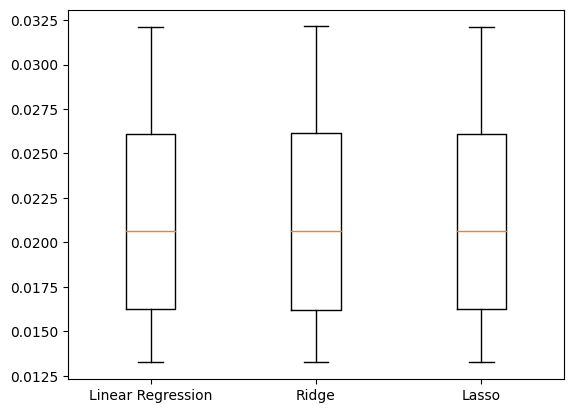

In [147]:
models = {"Linear Regression": LinearRegression(), "Ridge": Ridge(alpha=0.1), "Lasso": Lasso(alpha=0.1)}
results = []

# Loop through the models' values
for model in models.values():
  kf = KFold(n_splits=6, random_state=42, shuffle=True)

  # Perform cross-validation
  cv_scores = cross_val_score(model, X_train, y_train, cv=kf)

  # Append the results
  results.append(cv_scores)

# Create a box plot of the results
plt.boxplot(results, labels=models.keys())
plt.show()